# Task 3: Customer Segmentation / Clustering
Introduction In this task, we will perform customer segmentation using clustering techniques. The goal is to group customers into distinct segments based on their profile information and transaction history. This segmentation can help the company understand different customer groups, tailor marketing strategies, and improve overall business performance.

# Approach
1.Data Preparation: Load and merge the Customers.csv and Transactions.csv datasets. Preprocess the data, handle missing values, and perform necessary data cleaning.

2.Feature Engineering: Create customer profile features from Customers.csv (e.g., Region). Generate transaction-based features (e.g., Recency, Frequency, Monetary Value).

3.Clustering: Use clustering algorithms (e.g., K-Means) to segment customers. Determine the optimal number of clusters between 2 and 10 using clustering metrics.

4.Evaluation: Calculate clustering metrics, including the Davies-Bouldin Index (DB Index). Compute other relevant metrics like the Silhouette Score.

5.Visualization: Visualize the clusters using scatter plots and cluster profiles.

6.Reporting: Present the clustering results, including the number of clusters formed, DB Index value, and other metrics.

# 1. Import Necessary Libraries

In [58]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and clustering libraries
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors

# For dimensionality reduction (visualization)
from sklearn.decomposition import PCA

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')

# 2. Load and Prepare the Data

# 2.1 Load Datasets

In [59]:
# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Convert dates to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# 2.2 Merge Datasets

In [60]:
# Merge Transactions with Customers on 'CustomerID'
data_merged = pd.merge(transactions, customers, on='CustomerID', how='inner')

# 2.3 Preview Merged Data

In [61]:
# Display the first few rows
data_merged.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00761,C0199,P022,2024-10-01 05:57:09,4,550.16,137.54,Andrea Jenkins,Europe,2022-12-03
2,T00626,C0199,P079,2024-08-17 12:06:08,2,834.74,417.37,Andrea Jenkins,Europe,2022-12-03
3,T00963,C0199,P008,2024-10-26 00:01:58,2,293.70,146.85,Andrea Jenkins,Europe,2022-12-03
4,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04


# 3. Data Preprocessing


# 3.1 Handle Missing Values

## 3.2 Feature Selection
We will use the following features for clustering:

Profile Information:
Region (one-hot encoded)
Transaction Information:
Recency
Frequency
Monetary Value

In [62]:
# Check for missing values
print("Missing values in merged data:")
print(data_merged.isnull().sum())

# For this analysis, we'll assume there are no significant missing values

Missing values in merged data:
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
CustomerName       0
Region             0
SignupDate         0
dtype: int64


# 4. Feature Engineering


## 4.1 Calculate Recency, Frequency, Monetary Value (RFM)

In [63]:
# Reference date for recency calculation (one day after the last transaction date)
reference_date = data_merged['TransactionDate'].max() + pd.Timedelta(days=1)

# Calculate Recency (number of days since last purchase)
recency = data_merged.groupby('CustomerID')['TransactionDate'].max().reset_index()
recency['Recency'] = (reference_date - recency['TransactionDate']).dt.days
recency = recency[['CustomerID', 'Recency']]

# Calculate Frequency (number of transactions)
frequency = data_merged.groupby('CustomerID')['TransactionID'].nunique().reset_index()
frequency.columns = ['CustomerID', 'Frequency']

# Calculate Monetary Value (total spend)
monetary = data_merged.groupby('CustomerID')['TotalValue'].sum().reset_index()
monetary.columns = ['CustomerID', 'Monetary']

# Merge RFM features
rfm = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')

# 4.2 Encode Categorical Variables

In [64]:
# One-hot encode 'Region'
region_data = customers[['CustomerID', 'Region']].copy()
region_encoded = pd.get_dummies(region_data.set_index('CustomerID')['Region'])

# Merge with RFM data
rfm = rfm.set_index('CustomerID').join(region_encoded, how='left')

# 4.3 Final Feature Set

In [65]:
# Final feature set for clustering
features = rfm.copy()

# Fill any missing values (if any)
features.fillna(0, inplace=True)

# Display the feature set
features.head()

,Recency,Frequency,Monetary,Asia,Europe,North America,South America
CustomerID,,,,,,,
C0001,56,5,3354.52,False,False,False,True
C0002,26,4,1862.74,True,False,False,False
C0003,126,4,2725.38,False,False,False,True
C0004,5,8,5354.88,False,False,False,True
C0005,55,3,2034.24,True,False,False,False


# 5. Data Scaling

In [66]:
# Initialize scaler
scaler = StandardScaler()

# Fit and transform features (excluding CustomerID index)
scaled_features = scaler.fit_transform(features)

# Store the scaled features in a DataFrame for convenience
scaled_features_df = pd.DataFrame(scaled_features, index=features.index, columns=features.columns)

# 6. Clustering


### 6.1 Determine Optimal Number of Clusters for K-Means and Hierarchical Clustering
We will use the Elbow Method, Silhouette Score, and Davies-Bouldin Index to determine the optimal number of clusters.

In [67]:
# Range of clusters to try
cluster_range = range(2, 11)

# Lists to store evaluation metrics for K-Means
inertia_list = []
silhouette_scores = []
db_indexes = []

# Lists to store evaluation metrics for Hierarchical Clustering
silhouette_scores_hc = []
db_indexes_hc = []

for k in cluster_range:
    # K-Means Clustering
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10,
        algorithm='lloyd'
    )
    kmeans.fit(scaled_features)
    
    # Inertia (Within-cluster Sum of Squares)
    inertia = kmeans.inertia_
    inertia_list.append(inertia)
    
    # Silhouette Score for K-Means
    silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    
    # Davies-Bouldin Index for K-Means
    db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
    db_indexes.append(db_index)
    
    # Hierarchical Clustering
    agglom = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
    cluster_labels_hc = agglom.fit_predict(scaled_features)
    
    # Silhouette Score for Hierarchical Clustering
    silhouette_avg_hc = silhouette_score(scaled_features, cluster_labels_hc)
    silhouette_scores_hc.append(silhouette_avg_hc)
    
    # Davies-Bouldin Index for Hierarchical Clustering
    db_index_hc = davies_bouldin_score(scaled_features, cluster_labels_hc)
    db_indexes_hc.append(db_index_hc)

### 6.2 Plot Evaluation Metrics
K-Means: Inertia (Elbow Method)

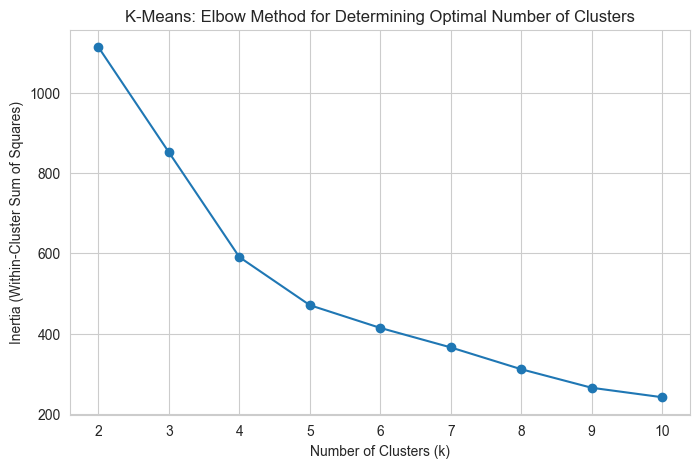

In [68]:
# Plot Inertia vs. Number of Clusters
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia_list, marker='o')
plt.title('K-Means: Elbow Method for Determining Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(cluster_range)
plt.show()

### K-Means: Silhouette Scores

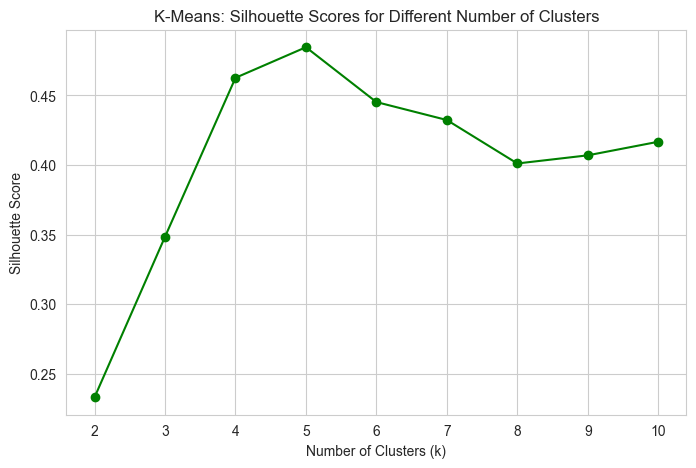

In [69]:
# Plot Silhouette Scores vs. Number of Clusters
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o', color='green')
plt.title('K-Means: Silhouette Scores for Different Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.show()

### K-Means: Davies-Bouldin Index

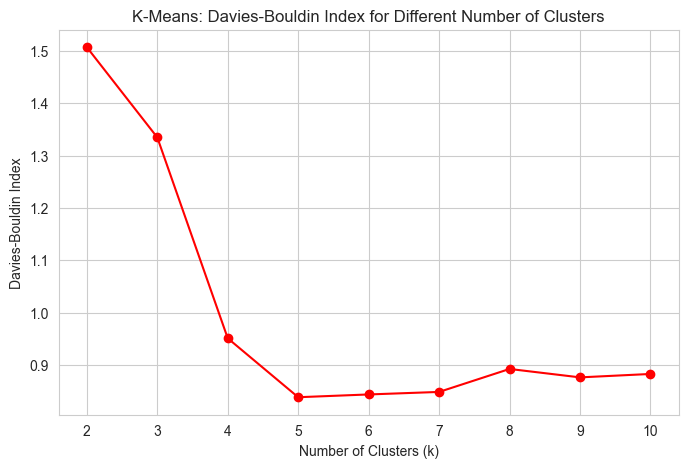

In [70]:
# Plot DB Index vs. Number of Clusters
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, db_indexes, marker='o', color='red')
plt.title('K-Means: Davies-Bouldin Index for Different Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(cluster_range)
plt.show()

### Hierarchical Clustering: Silhouette Scores

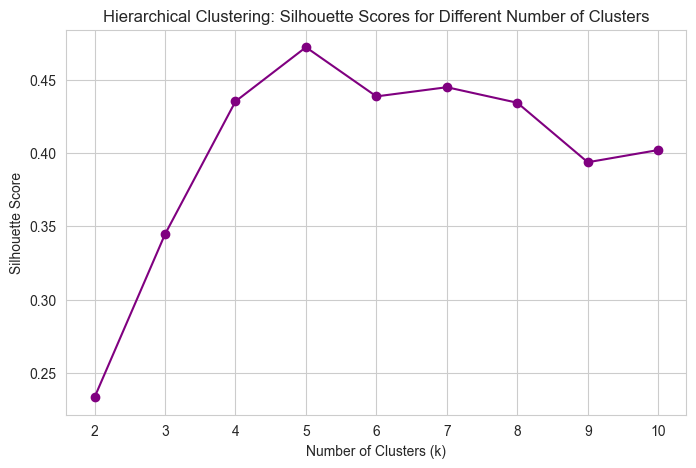

In [71]:
# Plot Silhouette Scores vs. Number of Clusters
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores_hc, marker='o', color='purple')
plt.title('Hierarchical Clustering: Silhouette Scores for Different Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.show()

### Hierarchical Clustering: Davies-Bouldin Index

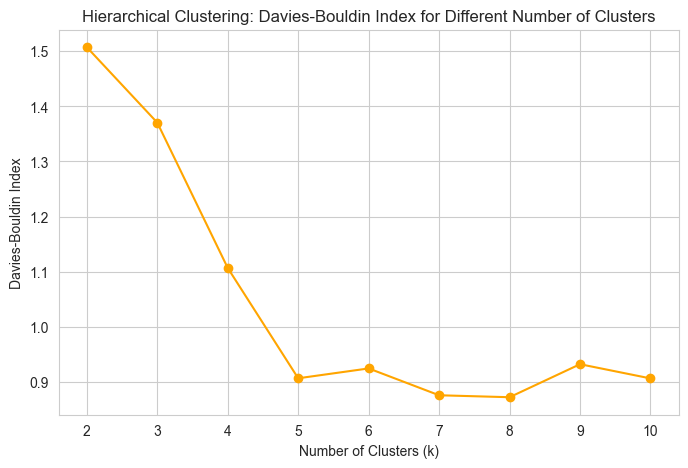

In [72]:
# Plot DB Index vs. Number of Clusters
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, db_indexes_hc, marker='o', color='orange')
plt.title('Hierarchical Clustering: Davies-Bouldin Index for Different Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(cluster_range)
plt.show()

### 6.3 Choose Optimal Number of Clusters
Based on the evaluation metrics, let's assume we decide that k = 5 provides a good balance for both K-Means and Hierarchical Clustering.

# 7. Applying Clustering Algorithms


### 7.1 K-Means Clustering

In [73]:
# Set number of clusters
optimal_k = 5

# Initialize and fit KMeans
kmeans = KMeans(
    n_clusters=optimal_k,
    random_state=42,
    n_init=10,
    algorithm='lloyd'
)
cluster_labels_kmeans = kmeans.fit_predict(scaled_features)

# Add cluster labels to the features DataFrame
features['Cluster_KMeans'] = cluster_labels_kmeans

### 7.2 Hierarchical Clustering

In [74]:
agglom = AgglomerativeClustering(
    n_clusters=optimal_k,
    metric='euclidean',  # Use 'metric' instead of 'affinity'
    linkage='ward'
)
cluster_labels_hc = agglom.fit_predict(scaled_features)

## 7.3 DBSCAN Clustering


### 7.3.1 Finding Optimal Parameters for DBSCAN

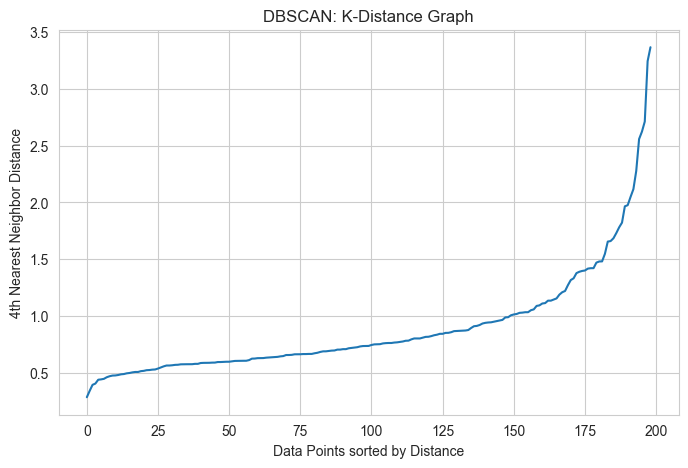

In [75]:
# Use NearestNeighbors to find the optimal eps
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)

# Plot the k-distance graph
distances = np.sort(distances[:, 4], axis=0)
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('DBSCAN: K-Distance Graph')
plt.xlabel('Data Points sorted by Distance')
plt.ylabel('4th Nearest Neighbor Distance')
plt.show()

### 7.3.2 Apply DBSCAN

In [76]:
# Initialize and fit DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
cluster_labels_dbscan = dbscan.fit_predict(scaled_features)

# Add cluster labels to the features DataFrame
features['Cluster_DBSCAN'] = cluster_labels_dbscan

# 8. Evaluation Metrics


### 8.1 K-Means Clustering Metrics

In [77]:
# Silhouette Score
silhouette_avg_kmeans = silhouette_score(scaled_features, cluster_labels_kmeans)
print(f"K-Means Silhouette Score for k={optimal_k}: {silhouette_avg_kmeans:.4f}")

# Davies-Bouldin Index
db_index_kmeans = davies_bouldin_score(scaled_features, cluster_labels_kmeans)
print(f"K-Means Davies-Bouldin Index for k={optimal_k}: {db_index_kmeans:.4f}")

K-Means Silhouette Score for k=5: 0.4846
K-Means Davies-Bouldin Index for k=5: 0.8381


### 8.2 Hierarchical Clustering Metrics

In [78]:
# Silhouette Score
silhouette_avg_hc = silhouette_score(scaled_features, cluster_labels_hc)
print(f"Hierarchical Clustering Silhouette Score for k={optimal_k}: {silhouette_avg_hc:.4f}")

# Davies-Bouldin Index
db_index_hc = davies_bouldin_score(scaled_features, cluster_labels_hc)
print(f"Hierarchical Clustering Davies-Bouldin Index for k={optimal_k}: {db_index_hc:.4f}")

Hierarchical Clustering Silhouette Score for k=5: 0.4721
Hierarchical Clustering Davies-Bouldin Index for k=5: 0.9063


### 8.3 DBSCAN Clustering Metrics

In [79]:
# Identify the number of clusters (excluding noise)
unique_clusters_dbscan = set(cluster_labels_dbscan)
n_clusters_dbscan = len(unique_clusters_dbscan) - (1 if -1 in cluster_labels_dbscan else 0)
print(f"DBSCAN estimated number of clusters: {n_clusters_dbscan}")

# Filter out noise for metrics
labels_dbscan = cluster_labels_dbscan[cluster_labels_dbscan != -1]
features_dbscan = scaled_features[cluster_labels_dbscan != -1]

# Silhouette Score
if n_clusters_dbscan > 1:
    silhouette_avg_dbscan = silhouette_score(features_dbscan, labels_dbscan)
    print(f"DBSCAN Silhouette Score: {silhouette_avg_dbscan:.4f}")
else:
    print("DBSCAN resulted in less than 2 clusters; Silhouette Score is not applicable.")

# Davies-Bouldin Index
if n_clusters_dbscan > 1:
    db_index_dbscan = davies_bouldin_score(features_dbscan, labels_dbscan)
    print(f"DBSCAN Davies-Bouldin Index: {db_index_dbscan:.4f}")
else:
    print("DBSCAN resulted in less than 2 clusters; Davies-Bouldin Index is not applicable.")

DBSCAN estimated number of clusters: 4
DBSCAN Silhouette Score: 0.4891
DBSCAN Davies-Bouldin Index: 0.8654


# 9. Visualization of Clusters
Since the data has multiple dimensions, we'll use PCA to reduce it to two principal components for visualization.

### 9.1 Dimensionality Reduction using PCA

In [80]:
# Reduce to 2 principal components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame with principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=features.index)
pca_df['Cluster_KMeans'] = cluster_labels_kmeans
pca_df['Cluster_HC'] = cluster_labels_hc
pca_df['Cluster_DBSCAN'] = cluster_labels_dbscan

### 9.2 Scatter Plot of Clusters


### K-Means Clustering Visualization

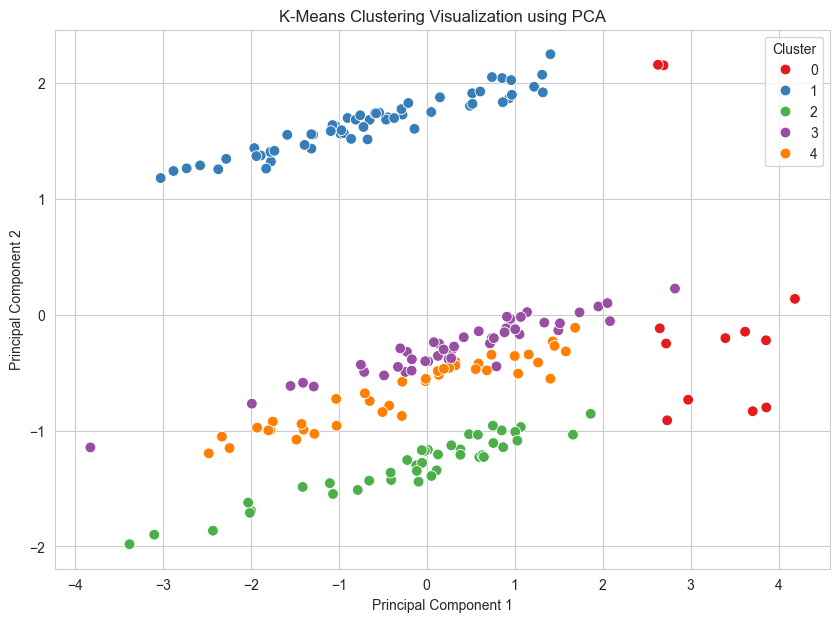

In [81]:
# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster_KMeans', palette='Set1', s=60)
plt.title('K-Means Clustering Visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

### Hierarchical Clustering Visualization

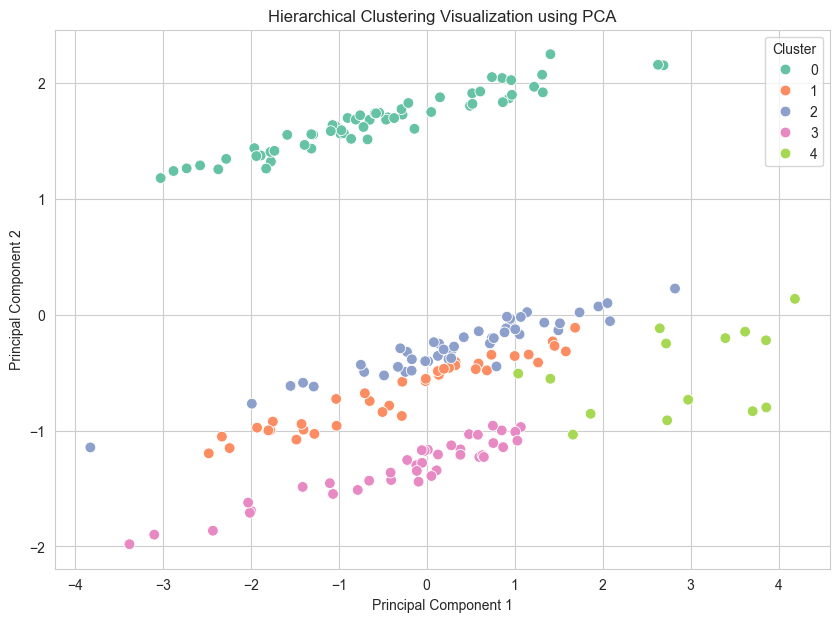

In [82]:
# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster_HC', palette='Set2', s=60)
plt.title('Hierarchical Clustering Visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


### DBSCAN Clustering Visualization

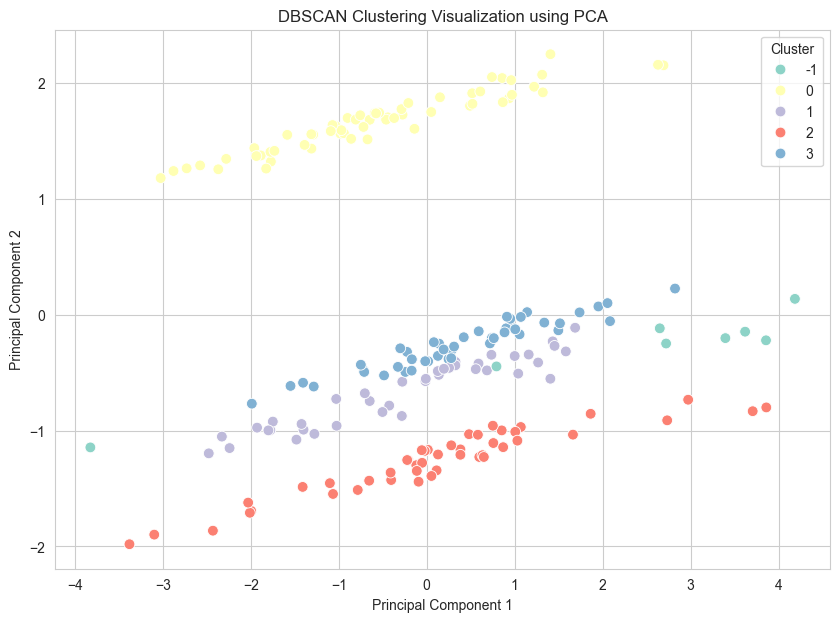

In [83]:
# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster_DBSCAN', palette='Set3', s=60)
plt.title('DBSCAN Clustering Visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# 10. Cluster Profiles
Let's analyze the clusters by calculating the mean value of features within each cluster.

### 10.1 K-Means Cluster Profiles

In [84]:
# Add Cluster labels back to the original RFM DataFrame
rfm['Cluster_KMeans'] = cluster_labels_kmeans

# Calculate mean values for each cluster
cluster_profiles_kmeans = rfm.groupby('Cluster_KMeans').mean()

# Display cluster profiles
print("K-Means Cluster Profiles:")
display(cluster_profiles_kmeans)

K-Means Cluster Profiles:


,Recency,Frequency,Monetary,Asia,Europe,North America,South America
Cluster_KMeans,,,,,,,
0,275.916667,1.333333,764.795000,0.333333,0.166667,0.333333,0.166667
1,58.491228,5.298246,3827.558947,0.000000,0.000000,0.000000,1.000000
2,68.000000,5.690476,3560.888810,0.000000,0.000000,1.000000,0.000000
3,66.354167,4.791667,3414.071458,0.000000,1.000000,0.000000,0.000000
4,55.425000,5.325000,3730.360000,1.000000,0.000000,0.000000,0.000000


### 10.2 Hierarchical Clustering Cluster Profiles

In [85]:
# Add Cluster labels back to the original RFM DataFrame
rfm['Cluster_HC'] = cluster_labels_hc

# Calculate mean values for each cluster
cluster_profiles_hc = rfm.groupby('Cluster_HC').mean()

# Display cluster profiles
print("Hierarchical Clustering Cluster Profiles:")
display(cluster_profiles_hc)

Hierarchical Clustering Cluster Profiles:


,Recency,Frequency,Monetary,Asia,Europe,North America,South America,Cluster_KMeans
Cluster_HC,,,,,,,,
0,64.050847,5.152542,3717.840000,0.000000,0.000000,0.000000,1.0,0.966102
1,48.368421,5.421053,3743.045000,1.000000,0.000000,0.000000,0.0,4.000000
2,66.354167,4.791667,3414.071458,0.000000,1.000000,0.000000,0.0,3.000000
3,64.575000,5.850000,3651.713250,0.000000,0.000000,1.000000,0.0,2.000000
4,251.285714,1.857143,1318.809286,0.428571,0.142857,0.428571,0.0,0.857143


### 10.3 DBSCAN Cluster Profiles

In [86]:
# Add Cluster labels back to the original RFM DataFrame
rfm['Cluster_DBSCAN'] = cluster_labels_dbscan

# Filter out noise points (-1)
rfm_dbscan = rfm[rfm['Cluster_DBSCAN'] != -1]

# Calculate mean values for each cluster
cluster_profiles_dbscan = rfm_dbscan.groupby('Cluster_DBSCAN').mean()

# Display cluster profiles
print("DBSCAN Cluster Profiles:")
display(cluster_profiles_dbscan)

DBSCAN Cluster Profiles:


,Recency,Frequency,Monetary,Asia,Europe,North America,South America,Cluster_KMeans,Cluster_HC
Cluster_DBSCAN,,,,,,,,,
0,64.050847,5.152542,3717.840000,0.0,0.0,0.0,1.0,0.966102,0.000000
1,55.425000,5.325000,3730.360000,1.0,0.0,0.0,0.0,4.000000,1.150000
2,85.695652,5.304348,3311.160870,0.0,0.0,1.0,0.0,1.826087,3.130435
3,63.630435,4.673913,3222.191087,0.0,1.0,0.0,0.0,3.000000,2.000000


###  Clustering Evaluation Metrics Summary

### Conclusion
While all three clustering methods offer valuable insights, K-Means Clustering provides the best balance between cluster quality and practical applicability in your case. It delivers well-separated and compact clusters that are interpretable and actionable, making it the most logical choice for proceeding with your customer segmentation analysis.